# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>

- Nicolas Schärer, 20-931-507, nicolasalexander.schaerer@uzh.ch
- Maxmilian Krägeloh, 23-754-088, maximilianwerner.kraegeloh@uzh.ch

In [59]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.optimization import MeanVariance
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver horse race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [60]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution

# here we went with a normal distributed mean, loc = mean = 3%, scale = std. deviation = 0.05
# could use .uniform instead low=0.01, high =0.1, size = N => here every value as likely as the other
mean = np.random.normal(loc=0.05, scale=0.03, size=N)
# cov = <your code here>
# Generate random standard deviations (volatility between 5% and 30%)
std_devs = np.random.uniform(0.05, 0.3, size=N)

# Create a random matrix
A = np.random.randn(N, N)

# Generate a positive semi-definite covariance matrix -> eigenwert isnt negative
cov = np.dot(A, A.T)

# Normalize and scale using std deviations
cov = (cov / np.max(np.abs(cov))) * np.outer(std_devs, std_devs)

# Generate the Multivariate-Normal random dataset random.multivariate_normal(mean, cov, size=T, check_valid='warn', tol=1e-8)
data = np.random.multivariate_normal(mean, cov, size=T, check_valid='warn', tol=1e-8)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
q = ExpectedReturn(method='geometric', scalefactor=1)
q.estimate(X=df, inplace=True)
#q = df.mean()

# Compute the covariance matrix from df
P  = Covariance(method='pearson')
P.estimate(X=df, inplace=True)
#P = df.cov()

# Display the results
print("Vector of expected returns (q):") #mean return of each asset over time
print(q.vector)

print("\nCovariance matrix (P):") #covariance matrix (how assets move together) -> isnt exactly the same as created due to randomness
print(P.matrix)

Vector of expected returns (q):
Asset_1      0.010127
Asset_2      0.030676
Asset_3      0.043441
Asset_4      0.032464
Asset_5      0.057008
               ...   
Asset_96     0.068967
Asset_97     0.038161
Asset_98     0.029162
Asset_99     0.033951
Asset_100    0.070681
Length: 100, dtype: float64

Covariance matrix (P):
            Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6  \
Asset_1    0.045684 -0.000059 -0.003026 -0.000187  0.005875 -0.011154   
Asset_2   -0.000059  0.066347 -0.002282  0.001320  0.000381  0.000983   
Asset_3   -0.003026 -0.002282  0.019547  0.000563  0.002757 -0.000292   
Asset_4   -0.000187  0.001320  0.000563  0.005331 -0.000346  0.001845   
Asset_5    0.005875  0.000381  0.002757 -0.000346  0.053893  0.002351   
...             ...       ...       ...       ...       ...       ...   
Asset_96  -0.005375 -0.001187 -0.002140 -0.000169 -0.002500 -0.003556   
Asset_97   0.000037 -0.000659  0.000700 -0.000266 -0.001631 -0.001820   
Asset_98  -0.0005

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [61]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0, upper=0.2)

# Add group constraints
G = pd.DataFrame(np.zeros((3, N)), columns=constraints.ids)
G.iloc[0, 0:30] = 1
G.iloc[1, 30:60] = 1
G.iloc[2, 60:100] = 1
h = pd.Series([0.3, 0.4, 0.5])
constraints.add_linear(G=G, sense='<=', rhs=h)

# Display the constraints
constraints.budget
constraints.box
constraints.linear


{'G':    Asset_1  Asset_2  Asset_3  Asset_4  Asset_5  Asset_6  Asset_7  Asset_8  \
 0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
 1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 
    Asset_9  Asset_10  ...  Asset_91  Asset_92  Asset_93  Asset_94  Asset_95  \
 0      1.0       1.0  ...       0.0       0.0       0.0       0.0       0.0   
 1      0.0       0.0  ...       0.0       0.0       0.0       0.0       0.0   
 2      0.0       0.0  ...       1.0       1.0       1.0       1.0       1.0   
 
    Asset_96  Asset_97  Asset_98  Asset_99  Asset_100  
 0       0.0       0.0       0.0       0.0        0.0  
 1       0.0       0.0       0.0       0.0        0.0  
 2       1.0       1.0       1.0       1.0        1.0  
 
 [3 rows x 100 columns],
 'sense': 0    <=
 dtype: object,
 'rhs': 0    0.3
 1    0.4
 2    0.5
 dtype: float64}

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [71]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
# Initialize results DataFrame
results = pd.DataFrame(index=['solution_found', 'objective', 'primal_residual', 'dual_residual', 'duality_gap', 'runtime'], columns=list(USABLE_SOLVERS))
all_weights = {}

for solver in USABLE_SOLVERS:
    #print("solver: ", solver)

    # Instantiate the quadratic program
    mv = MeanVariance(
        covariance=P,
        expected_return=q,
        constraints=constraints,
        risk_aversion=1,
        solver_name=solver,
    )
    
    # Create an OptimizationData object
    optimization_data = OptimizationData(return_series=df)

    # Set the objective function
    mv.set_objective(optimization_data=optimization_data)

    # Solve the optimization problem
    start_time = timeit.default_timer()
    mv.solve()
    end_time = timeit.default_timer()
    runtime = end_time - start_time

    # Extract the optimal weights and solution status
    solution_found = mv.results['status']

    if solution_found:
        # Extract the optimal weights
        weights = pd.Series(mv.results['weights'], index=df.columns)
        #print(weights)
        # Save the weights for later use
        all_weights[solver] = weights

        #objective_value = mv.model.objective_value()
        #print("objective_value: ", objective_value)
        objective_value = solution_obj.extras['primal objective']
        #print("objective_value2: ", objective_value2)

        # Calculate objective value
        # From objective function: 0.5 * x^T P x + q^T x
        #P_matrix = mv.objective.coefficients['P']
        #q_vector = mv.objective.coefficients['q']
        ##objective_value = 0.5 * weights @ P_matrix @ weights + q_vector @ weights
        #objective_value = 0.5 * (weights @ P_matrix @ weights) + q_vector @ weights

        # Calculate primal residual
        # For equality constraints (Ax = b)
        #A, b = GhAb['A'], GhAb['b']
        #print("A @ weights - b:", A @ weights - b)
        #primal_eq_residual = np.linalg.norm(A @ weights - b) if A.shape[0] > 0 else 0
        #print("primal_eq_residual: ",primal_eq_residual)
        
        # For inequality constraints (Gx <= h)
        #G, h = GhAb['G'], GhAb['h']
        #slack = G @ weights - h
        #print("slack: ", slack)
        #primal_ineq_residual = np.linalg.norm(np.maximum(slack, 0))
        #primal_ineq_residual = np.linalg.norm(np.minimum(slack, 0))  # Check negative violations
        #print("primal_ineq_residual: ",primal_ineq_residual)
        
        # Box constraints
        #lower = constraints.box['lower']
        #upper = constraints.box['upper']
        #lb_violation = np.linalg.norm(np.maximum(0, lower - weights))
        #ub_violation = np.linalg.norm(np.maximum(0, weights - upper))
        
        # Total primal residual
        #primal_residual = primal_eq_residual + primal_ineq_residual + lb_violation + ub_violation

        # Dual residual calculation
        solution_obj = mv.model.results['solution']
        #print("solution_obj: ", solution_obj)

        primal_residual = solution_obj.extras['primal infeasibility']
        dual_residual = solution_obj.extras['dual infeasibility']
        duality_gap = solution_obj.extras['gap']
    else:
        # If no solution was found, set metrics to NaN
        objective_value = np.nan
        primal_residual = np.nan
        dual_residual = np.nan
        duality_gap = np.nan
   
    # Store the results in the results DataFrame
    results.loc['solution_found', solver] = solution_found
    results.loc['objective', solver] = objective_value
    results.loc['primal_residual', solver] = primal_residual
    results.loc['dual_residual', solver] = dual_residual
    results.loc['duality_gap', solver] = duality_gap
    results.loc['runtime', solver] = runtime



Print and visualize the results

In [72]:
# Format specific rows with scientific notation
styled_results = results.style.format({
    'primal_residual': '{:.10e}',
    'dual_residual': '{:.10e}',
    'duality_gap': '{:.10e}'
})

styled_results

,qpalm,osqp,quadprog,cvxopt,daqp,highs
solution_found,True,True,True,True,True,True
objective,-0.084647,-0.084647,-0.084647,-0.084647,-0.084647,-0.084647
primal_residual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dual_residual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
duality_gap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
runtime,0.030363,0.029333,0.027463,0.028881,0.028174,0.028842


## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


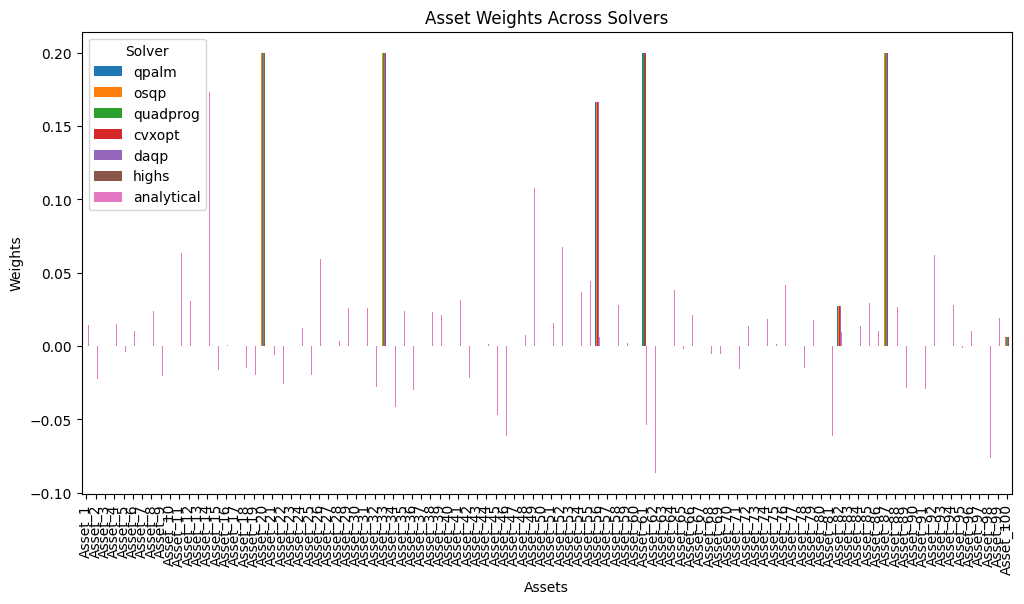

In [ ]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        # Store the return series and prepare covariance if not set
        self.return_series = optimization_data.return_series
        if self.covariance.matrix is None:
            self.covariance.matrix = np.cov(self.return_series.T)

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            # Analytical solution for minimum variance portfolio
            # Formula: w = (inv(C) * 1) / (1^T * inv(C) * 1)
            # where C is covariance matrix, 1 is vector of ones
            
            cov_matrix = self.covariance.matrix
            ones = np.ones(len(self.constraints.ids))
            
            # Calculate inverse of covariance matrix
            inv_cov = np.linalg.inv(cov_matrix)
            
            # Calculate weights
            numerator = inv_cov @ ones
            denominator = ones.T @ inv_cov @ ones
            self.weights = numerator / denominator
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
new_constraints = Constraints(ids = df.columns.tolist())
new_constraints.add_budget(rhs=1, sense='=')
new_constraints.budget

# Instantiate the MinVariance class
min_var = MinVariance(
    constraints=constraints,
    covariance=P,
    solver_name='analytical'
)

# Prepare the optimization data and prepare the optimization problem
opt_data = OptimizationData(return_series=df)
min_var.set_objective(optimization_data=opt_data)

# Solve the optimization problem and print the weights
min_var.solve()

# Store the weights in the all_weights dictionary
all_weights['analytical'] = min_var.weights

# Convert analytical solution to pandas Series
asset_names = list(all_weights['qpalm'].index)  
all_weights['analytical'] = pd.Series(all_weights['analytical'], index=asset_names)

#print(all_weights)

# Plot the weights
df_weights = pd.DataFrame(all_weights)  # Convert dictionary to DataFrame

df_weights.plot(kind='bar', figsize=(12, 6))  # Plot each solver's weights
plt.title("Asset Weights Across Solvers")
plt.xlabel("Assets")
plt.ylabel("Weights")
plt.legend(title="Solver")
plt.show()



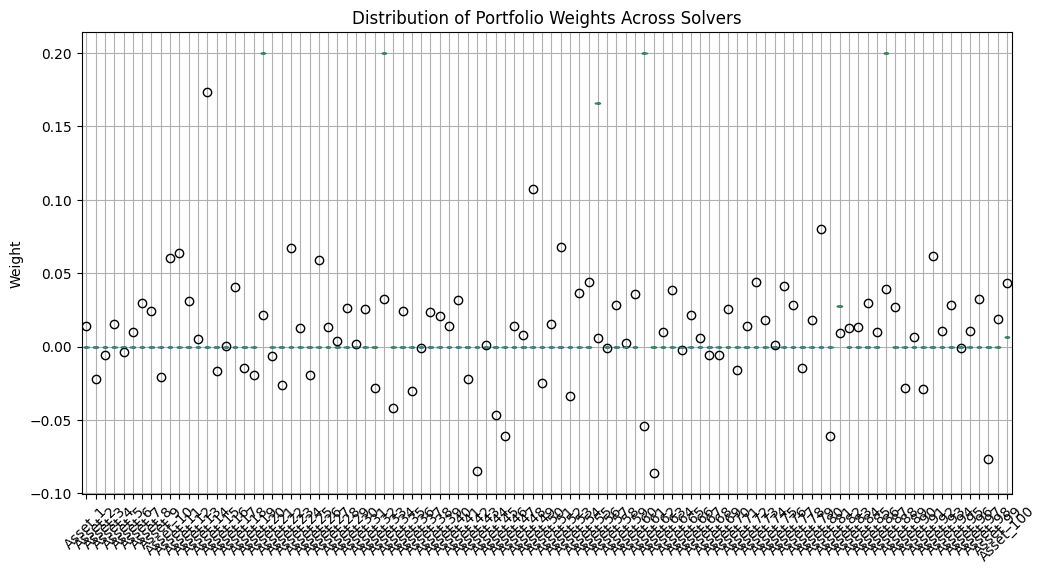

In [79]:
df_weights.T.boxplot(figsize=(12, 6))
plt.title("Distribution of Portfolio Weights Across Solvers")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.show()